In [1]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.metrics import fowlkes_mallows_score, silhouette_score
import numpy as np
from PIL import Image
from sklearn.preprocessing import StandardScaler
from pathlib import Path

base_directory = r"C:\Users\kaushal\Pictures\New folder"
dog_breed_folders = [folder for folder in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, folder))]
dog_breed_folders = [folder.strip('"') for folder in dog_breed_folders]

print("Dog Breed Folders:", dog_breed_folders)


Dog Breed Folders: ['n02090622-borzoi', 'n02101388-Brittany_spaniel', 'n02105505-komondor', 'n02107142-Doberman']


In [4]:

def resize_and_normalize(image_path):

    img = Image.open(image_path)
    

    img = img.resize((224, 224))

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_normalized = transform(img)

    return img_normalized

def extract_features(img_normalized, model):
    model.eval()
    with torch.no_grad():
        features = model(img_normalized.unsqueeze(0))
    return features.squeeze()

resnet_model = models.resnet18(pretrained=True)
resnet_model = torch.nn.Sequential(*(list(resnet_model.children())[:-1]))

output_directory = r"C:\Users\kaushal\Pictures\New folder (8)"

Path(output_directory).mkdir(parents=True, exist_ok=True)

for folder in dog_breed_folders:
    folder_path = os.path.join(base_directory, folder)
    output_folder = os.path.join(output_directory, folder)
    
    Path(output_folder).mkdir(parents=True, exist_ok=True)
    
    for image_file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_file)
        
        img_normalized = resize_and_normalize(image_path)

        features = extract_features(img_normalized, resnet_model)

        output_filename = os.path.splitext(image_file)[0] + "_features.npy"
        output_filepath = os.path.join(output_folder, output_filename)
        np.save(output_filepath, features.numpy())


Reference:   https://kozodoi.me/blog/20210527/extracting-features.

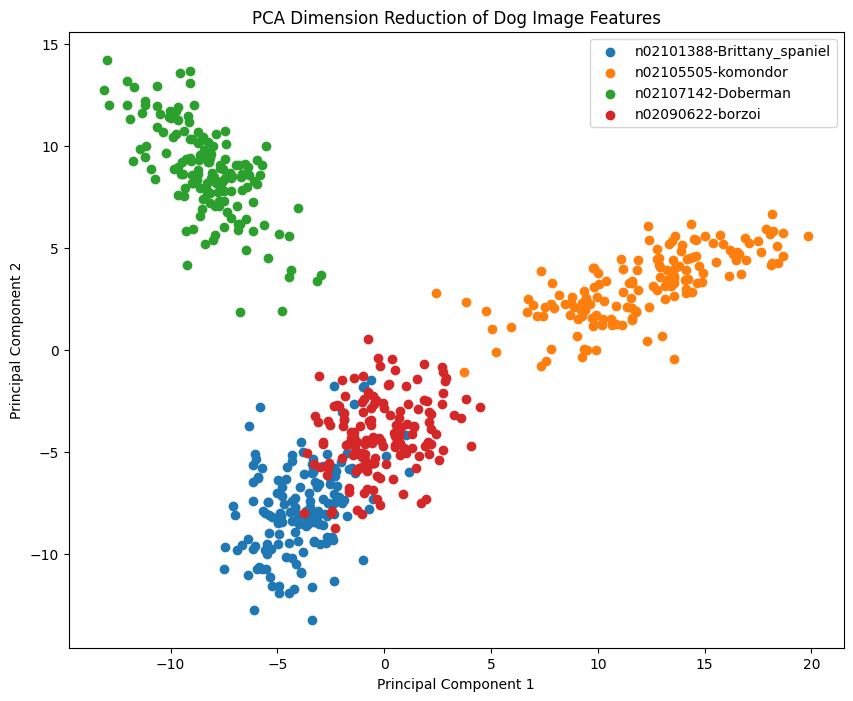

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os

features_directory = r"C:\Users\kaushal\Pictures\New folder (8)"

features_list = []
labels = []

# Load 
for folder in dog_breed_folders:
    folder_path = os.path.join(features_directory, folder)
    
    for features_file in os.listdir(folder_path):
        features_path = os.path.join(folder_path, features_file)
        
        # Load features and append to the list
        features = np.load(features_path)
        features_list.append(features)
        
        # Append label based on the folder name
        labels.append(folder)

features_array = np.array(features_list)

pca = PCA(n_components=2)
features_reduced = pca.fit_transform(features_array)

plt.figure(figsize=(10, 8))
for i, label in enumerate(set(labels)):
    indices = [j for j, l in enumerate(labels) if l == label]
    plt.scatter(features_reduced[indices, 0], features_reduced[indices, 1], label=label)

plt.title('PCA Dimension Reduction of Dog Image Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


c:\Users\kaushal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


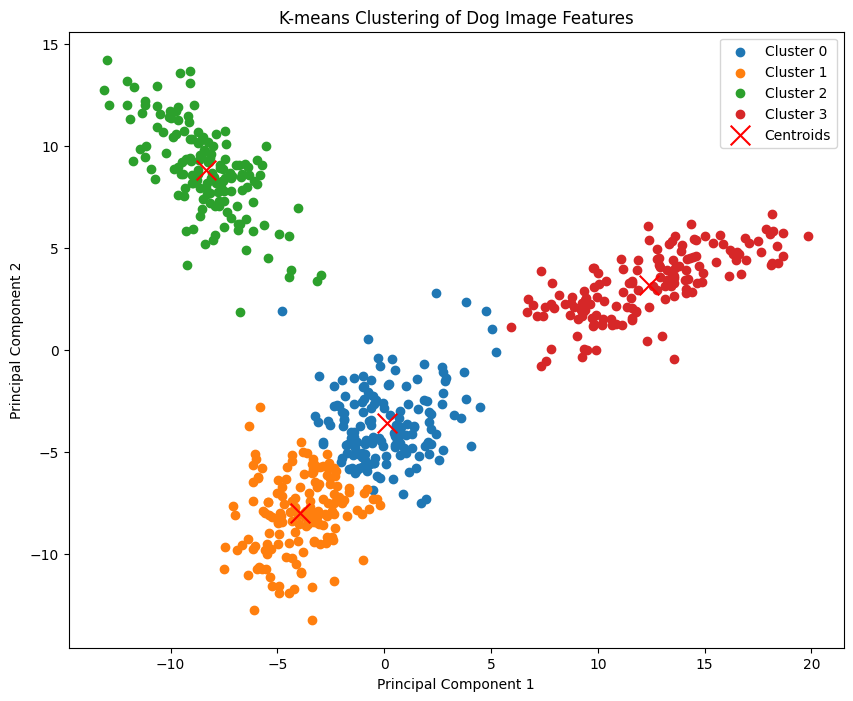

In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=4, init='random', random_state=42)
clusters = kmeans.fit_predict(features_reduced)

plt.figure(figsize=(10, 8))
for i in range(4):
    indices = np.where(clusters == i)
    plt.scatter(features_reduced[indices, 0], features_reduced[indices, 1], label=f'Cluster {i}')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', s=200, c='red', label='Centroids')
plt.title('K-means Clustering of Dog Image Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


c:\Users\kaushal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


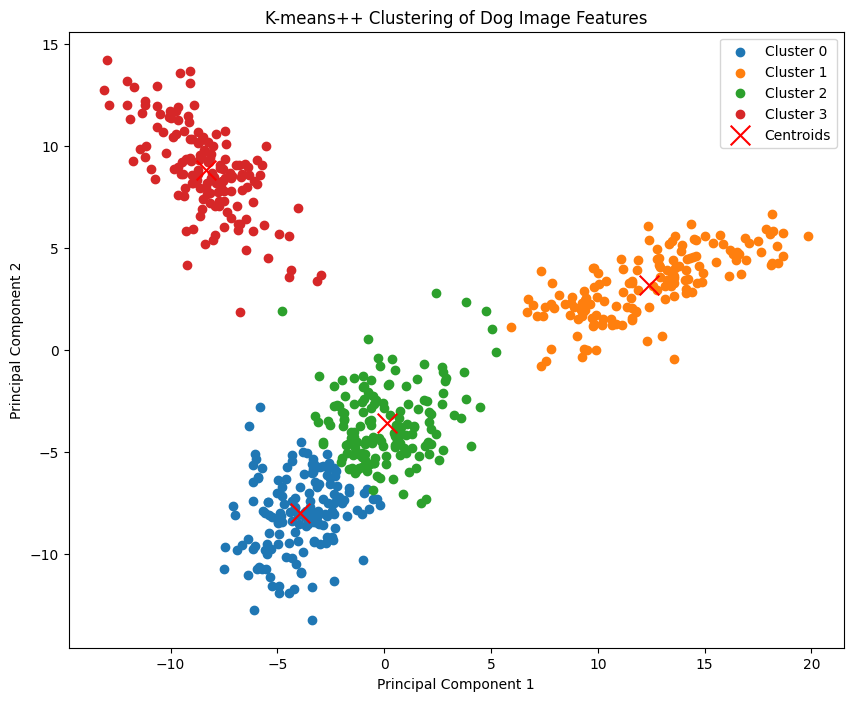

In [7]:

kmeans_pp = KMeans(n_clusters=4, init='k-means++', random_state=42)
clusters_pp = kmeans_pp.fit_predict(features_reduced)

plt.figure(figsize=(10, 8))
for i in range(4):
    indices = np.where(clusters_pp == i)
    plt.scatter(features_reduced[indices, 0], features_reduced[indices, 1], label=f'Cluster {i}')

plt.scatter(kmeans_pp.cluster_centers_[:, 0], kmeans_pp.cluster_centers_[:, 1], marker='x', s=200, c='red', label='Centroids')
plt.title('K-means++ Clustering of Dog Image Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


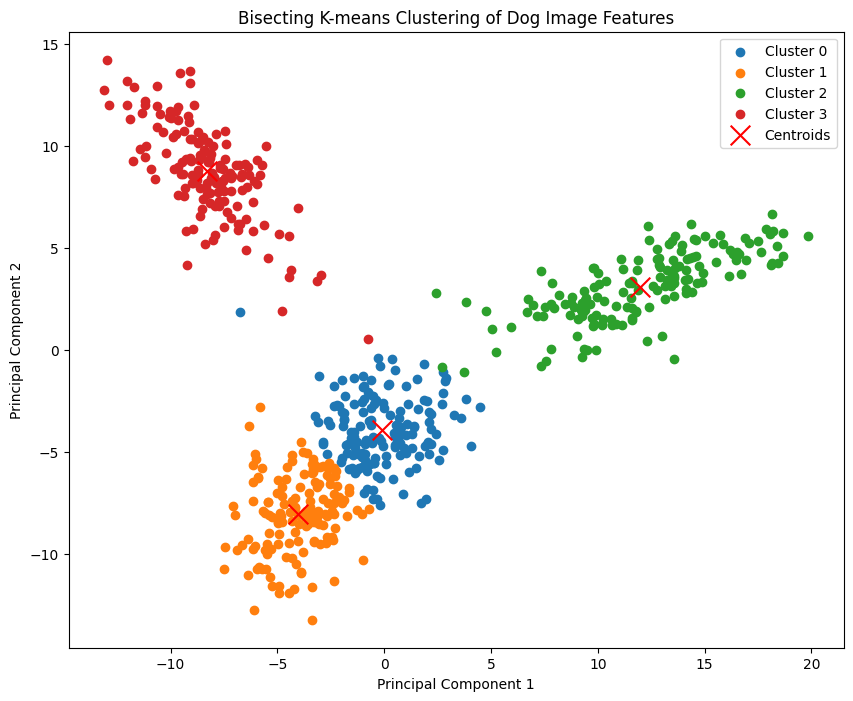

In [8]:

bisecting_kmeans = BisectingKMeans(n_clusters=4, init='random', random_state=42)
clusters_bisecting = bisecting_kmeans.fit_predict(features_reduced)

plt.figure(figsize=(10, 8))
for i in range(4):
    indices = np.where(clusters_bisecting == i)
    plt.scatter(features_reduced[indices, 0], features_reduced[indices, 1], label=f'Cluster {i}')

plt.scatter(bisecting_kmeans.cluster_centers_[:, 0], bisecting_kmeans.cluster_centers_[:, 1], marker='x', s=200, c='red', label='Centroids')
plt.title('Bisecting K-means Clustering of Dog Image Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


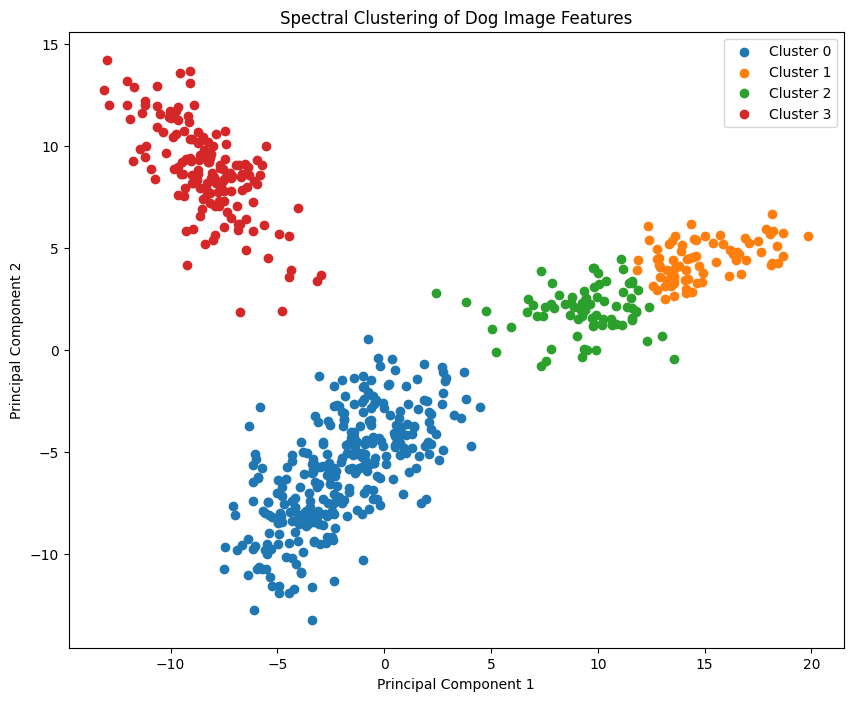

In [9]:

spectral_clustering = SpectralClustering(n_clusters=4, random_state=42)
clusters_spectral = spectral_clustering.fit_predict(features_reduced)

plt.figure(figsize=(10, 8))
for i in range(4):
    indices = np.where(clusters_spectral == i)
    plt.scatter(features_reduced[indices, 0], features_reduced[indices, 1], label=f'Cluster {i}')

plt.title('Spectral Clustering of Dog Image Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


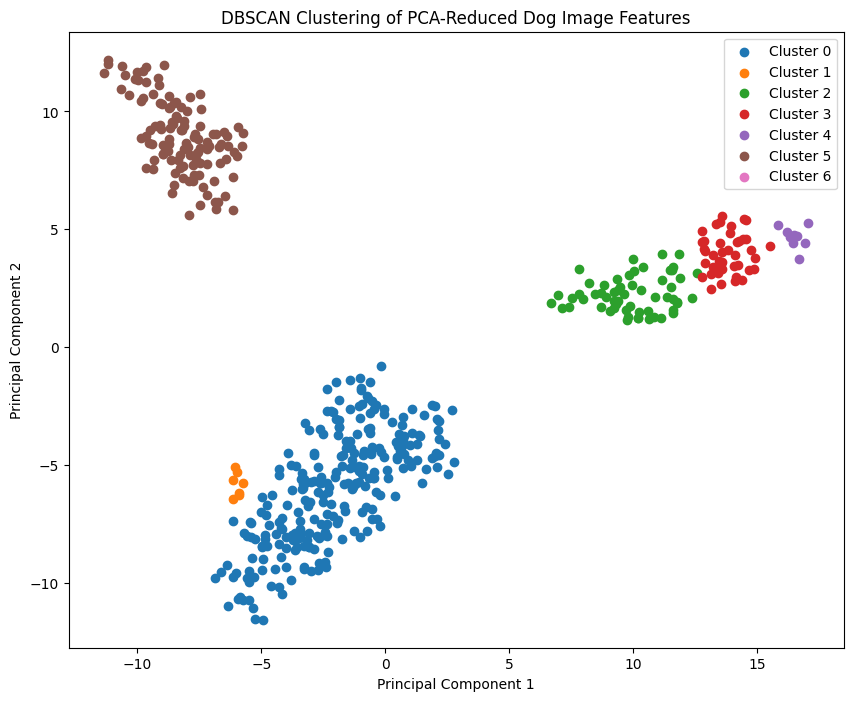

In [11]:

your_eps_value = 0.8
your_min_samples_value = 7

dbscan = DBSCAN(eps=your_eps_value, min_samples=your_min_samples_value)
clusters_dbscan = dbscan.fit_predict(features_reduced)

plt.figure(figsize=(10, 8))
for i in range(len(set(clusters_dbscan))):
    indices = np.where(clusters_dbscan == i)
    plt.scatter(features_reduced[indices, 0], features_reduced[indices, 1], label=f'Cluster {i}')

plt.title('DBSCAN Clustering of PCA-Reduced Dog Image Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


I have taken the eps value 0.8 and min samples value 7

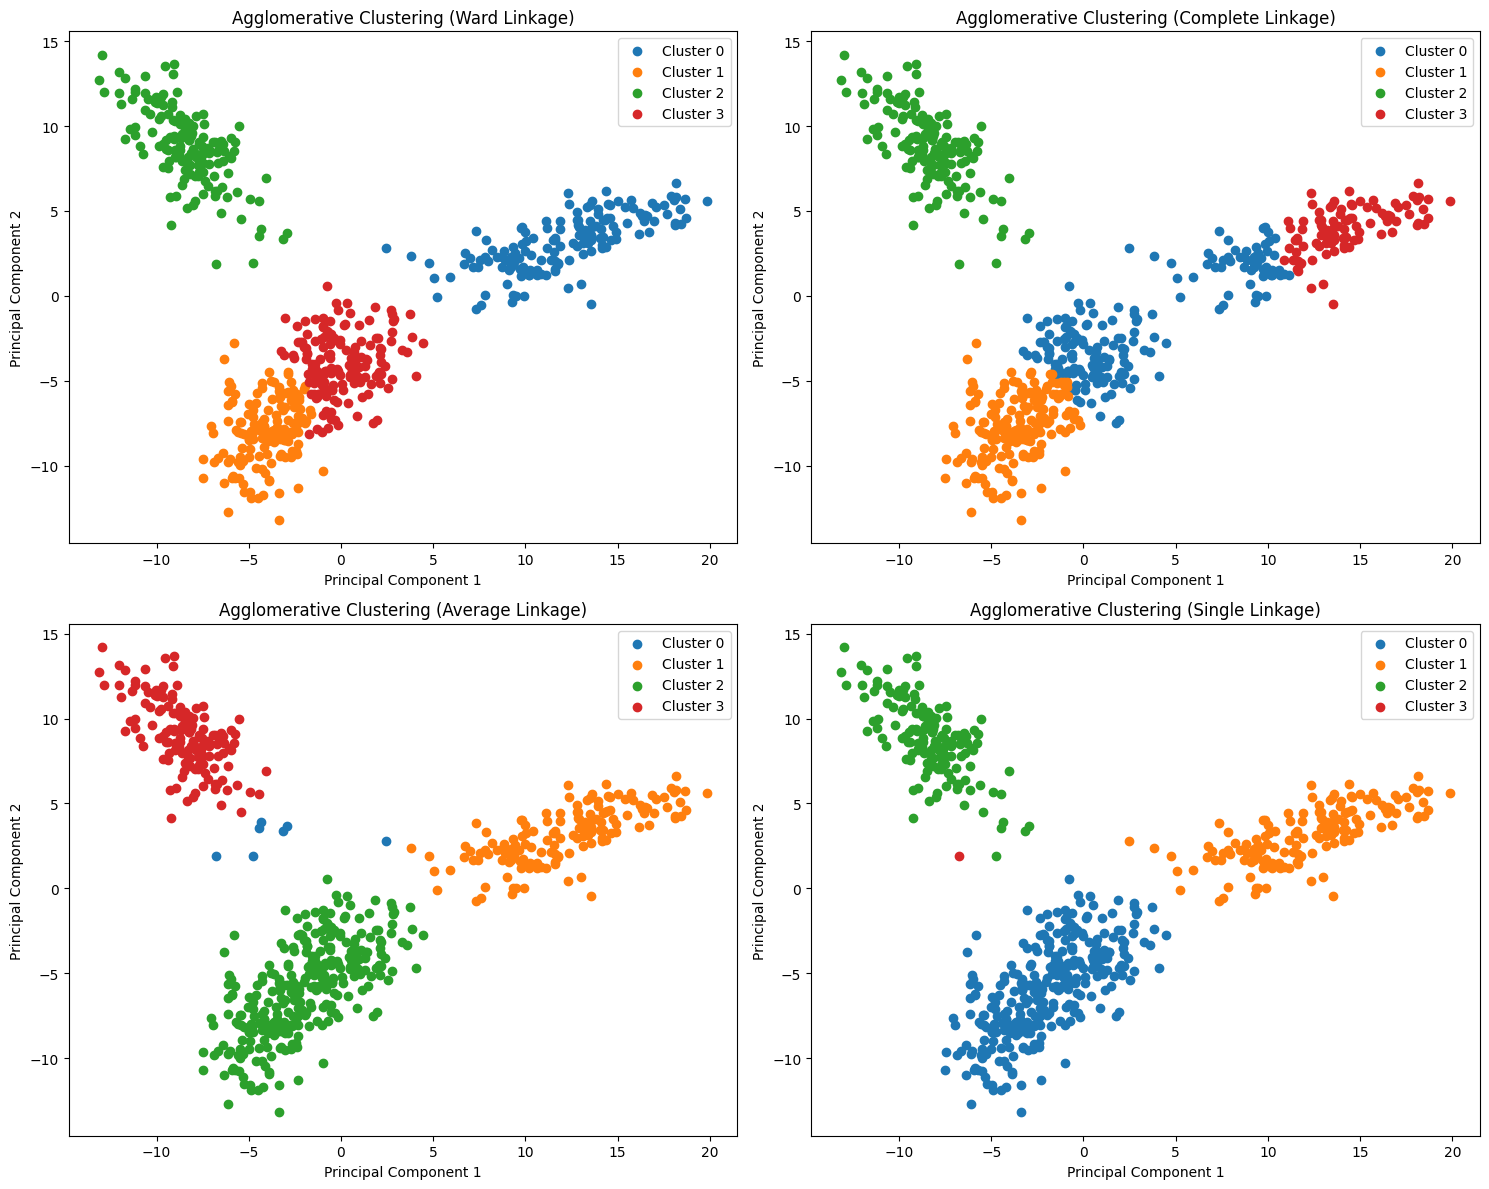

In [16]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

linkage_methods = ['ward', 'complete', 'average', 'single']

plt.figure(figsize=(15, 12))

for i, linkage_method in enumerate(linkage_methods, start=1):
    
    agglomerative_clustering = AgglomerativeClustering(n_clusters=4, linkage=linkage_method)
    clusters = agglomerative_clustering.fit_predict(features_reduced)

   
    plt.subplot(2, 2, i)
    for j in range(len(set(clusters))):
        indices = np.where(clusters == j)
        plt.scatter(features_reduced[indices, 0], features_reduced[indices, 1], label=f'Cluster {j}')

    plt.title(f"Agglomerative Clustering ({linkage_method.capitalize()} Linkage)")
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()

plt.tight_layout()
plt.show()


In [19]:
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, BisectingKMeans
from sklearn.metrics import fowlkes_mallows_score, silhouette_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

methods = [
    {'name': 'K-means (Random)', 'init': 'random'},
    {'name': 'K-means (k-means++)', 'init': 'k-means++'},
    {'name': 'Bisecting K-means', 'init': 'random'},
    {'name': 'Spectral Clustering', 'init': None},
    {'name': 'DBSCAN', 'eps': 0.8, 'min_samples': 7},
    {'name': 'Agglomerative (Single Link)', 'linkage': 'single'},
    {'name': 'Agglomerative (Complete Link)', 'linkage': 'complete'},
    {'name': 'Agglomerative (Group Average)', 'linkage': 'average'},
    {'name': "Agglomerative (Ward's Method)", 'linkage': 'ward'}
]


for method in methods:
    if 'eps' in method:
       
        dbscan = DBSCAN(eps=method['eps'], min_samples=method['min_samples'])
        clusters = dbscan.fit_predict(features_reduced)
    else:
        
        if 'init' in method:
            kmeans = KMeans(n_clusters=4, init=method['init'], random_state=42)
        elif 'linkage' in method:
            agglomerative = AgglomerativeClustering(n_clusters=4, linkage=method['linkage'])
        else:
            spectral = SpectralClustering(n_clusters=4, random_state=42)
            clusters = spectral.fit_predict(features_reduced)

    
    fm_score = fowlkes_mallows_score(labels, clusters)

    
    silhouette_coefficient = silhouette_score(features_reduced, clusters)

    
    print(f"Method: {method['name']}")
    print(f"Fowlkes-Mallows Index: {fm_score}")
    print(f"Silhouette Coefficient: {silhouette_coefficient}")
    print("------------------------")


Method: K-means (Random)
Fowlkes-Mallows Index: 0.8106677877185817
Silhouette Coefficient: 0.551110565662384
------------------------
Method: K-means (k-means++)
Fowlkes-Mallows Index: 0.8106677877185817
Silhouette Coefficient: 0.551110565662384
------------------------
Method: Bisecting K-means
Fowlkes-Mallows Index: 0.8106677877185817
Silhouette Coefficient: 0.551110565662384
------------------------
Method: Spectral Clustering
Fowlkes-Mallows Index: 0.8106677877185817
Silhouette Coefficient: 0.551110565662384
------------------------
Method: DBSCAN
Fowlkes-Mallows Index: 0.5750437885597115
Silhouette Coefficient: 0.16921298205852509
------------------------
Method: Agglomerative (Single Link)
Fowlkes-Mallows Index: 0.5750437885597115
Silhouette Coefficient: 0.16921298205852509
------------------------
Method: Agglomerative (Complete Link)
Fowlkes-Mallows Index: 0.5750437885597115
Silhouette Coefficient: 0.16921298205852509
------------------------
Method: Agglomerative (Group Averag

In [21]:

for method in methods:
    if 'eps' in method:
       
        dbscan = DBSCAN(eps=method['eps'], min_samples=method['min_samples'])
        clusters = dbscan.fit_predict(features_reduced)
    else:
        if 'init' in method:
          
            if method['init'] is not None:
                kmeans = KMeans(n_clusters=4, init=method['init'], random_state=42)
                clusters = kmeans.fit_predict(features_reduced)
            else:
                
                spectral = SpectralClustering(n_clusters=4, random_state=42)
                clusters = spectral.fit_predict(features_reduced)
        elif 'linkage' in method:
            
            agglomerative = AgglomerativeClustering(n_clusters=4, linkage=method['linkage'])
            clusters = agglomerative.fit_predict(features_reduced)

    
    fm_score = fowlkes_mallows_score(labels, clusters)
    fm_scores.append((method['name'], fm_score))

    
    silhouette_coefficient = silhouette_score(features_reduced, clusters)
    silhouette_scores.append((method['name'], silhouette_coefficient))


fm_scores.sort(key=lambda x: x[1], reverse=True)
print("Ranking based on Fowlkes-Mallows Index:")
for rank, (method, score) in enumerate(fm_scores, start=1):
    print(f"{rank}. {method}: {score}")


silhouette_scores.sort(key=lambda x: x[1], reverse=True)
print("\nRanking based on Silhouette Coefficient:")
for rank, (method, score) in enumerate(silhouette_scores, start=1):
    print(f"{rank}. {method}: {score}")


c:\Users\kaushal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\kaushal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\kaushal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Ranking based on Fowlkes-Mallows Index:
1. Agglomerative (Ward's Method): 0.9018969362702713
2. K-means (Random): 0.8799423298026359
3. K-means (k-means++): 0.8799423298026359
4. Bisecting K-means: 0.8799423298026359
5. K-means (Random): 0.8799423298026359
6. K-means (k-means++): 0.8799423298026359
7. Bisecting K-means: 0.8799423298026359
8. Agglomerative (Single Link): 0.8106677877185817
9. Agglomerative (Group Average): 0.8002349138525946
10. Spectral Clustering: 0.7403733341187664
11. Agglomerative (Complete Link): 0.7365743312272183
12. DBSCAN: 0.5750437885597115

Ranking based on Silhouette Coefficient:
1. Spectral Clustering: 0.6465124487876892
2. K-means (Random): 0.593705952167511
3. K-means (k-means++): 0.593705952167511
4. Bisecting K-means: 0.593705952167511
5. K-means (Random): 0.593705952167511
6. K-means (k-means++): 0.593705952167511
7. Bisecting K-means: 0.593705952167511
8. Agglomerative (Ward's Method): 0.5874227285385132
9. Agglomerative (Group Average): 0.5705863237